## **Інформація про вміст дата сету**

In [19]:
import os
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import seaborn as sns
import matplotlib.pyplot as plt


In [20]:
files = [f for f in os.listdir('.') if f.endswith('.csv')]

if files:
    print(f"Data sets: {len(files)}")
    print(files)
else:
    print("This folder doesn't contain any data set")

Data sets: 2
['global-data-on-sustainable-energy.csv', 'global_energy_clean.csv']


In [21]:
df = pd.read_csv('global-data-on-sustainable-energy.csv')

# print(df.head)


In [22]:
def name_change(df):
    new_column_names = {
        'Access to electricity (% of population)': 'elec_access',
        'Access to clean fuels for cooking': 'clean_cooking',
        'Renewable-electricity-generating-capacity-per-capita': 'renew_capacity_pc',
        'Financial flows to developing countries (US $)': 'fin_flows',
        'Renewable energy share in the total final energy consumption (%)': 'renew_share_total',
        'Electricity from fossil fuels (TWh)': 'elec_fossil',
        'Electricity from nuclear (TWh)': 'elec_nuclear',
        'Electricity from renewables (TWh)': 'elec_renew',
        'Low-carbon electricity (% electricity)': 'low_carbon_pct',
        'Primary energy consumption per capita (kWh/person)': 'energy_pc',
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'energy_intensity',
        'Value_co2_emissions_kt_by_country': 'co2_total_kt',
        'Renewables (% equivalent primary energy)': 'renew_pct_primary',
        'Density\\n(P/Km2)': 'pop_density',
        'Land Area(Km2)': 'land_area'
    }

    print(df.columns.tolist())

    df.rename(columns=new_column_names, inplace=True)
    print('\n Після зміни назв колонки:')
    print(df.columns.tolist())

    # print(df.info())

In [23]:
name_change(df)

['Entity', 'Year', 'Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)', 'Renewable energy share in the total final energy consumption (%)', 'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Value_co2_emissions_kt_by_country', 'Renewables (% equivalent primary energy)', 'gdp_growth', 'gdp_per_capita', 'Density\\n(P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude']

 Після зміни назв колонки:
['Entity', 'Year', 'elec_access', 'clean_cooking', 'renew_capacity_pc', 'fin_flows', 'renew_share_total', 'elec_fossil', 'elec_nuclear', 'elec_renew', 'low_carbon_pct', 'energy_pc', 'energy_intensity', 'co2_total_kt', 'renew_pct_primary', 'gdp_growth', 

## Data Cleaning

In [24]:
df.isnull().sum()

Entity                  0
Year                    0
elec_access            10
clean_cooking         169
renew_capacity_pc     931
fin_flows            2089
renew_share_total     194
elec_fossil            21
elec_nuclear          126
elec_renew             21
low_carbon_pct         42
energy_pc               0
energy_intensity      207
co2_total_kt          428
renew_pct_primary    2137
gdp_growth            317
gdp_per_capita        282
pop_density             1
land_area               1
Latitude                1
Longitude               1
dtype: int64

In [25]:
def fill_null(name):
    df[name] = df[name].fillna(0)

In [26]:
fill_null('fin_flows')
fill_null('renew_capacity_pc')
fill_null('elec_nuclear')

In [27]:
df = df[df['Entity'] != 'French Guiana']

In [28]:
cols_to_fix = ['elec_access', 'clean_cooking', 'renew_share_total', 
               'elec_fossil', 'elec_renew', 'low_carbon_pct', 
               'energy_intensity', 'gdp_growth', 'gdp_per_capita']

df = df[df['Entity'] != 'French Guiana']

df[cols_to_fix] = df.groupby('Entity')[cols_to_fix].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

const_cols = ['land_area', 'pop_density', 'Latitude', 'Longitude']

df[const_cols] = df.groupby('Entity')[const_cols].ffill().bfill()

In [29]:
numeric_cols = [
    'land_area', 'pop_density', 'gdp_per_capita', 'co2_total_kt', 
    'elec_access', 'clean_cooking', 'renew_share_total', 
    'elec_fossil', 'elec_renew', 'elec_nuclear', 'low_carbon_pct', 
    'energy_intensity', 'gdp_growth', 'energy_pc'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [30]:
df.drop(columns=['renew_pct_primary'], inplace=True)

In [31]:
cols_cannot_be_zero = ['gdp_per_capita', 'co2_total_kt', 'energy_pc', 'elec_access']
df[cols_cannot_be_zero] = df[cols_cannot_be_zero].replace(0, np.nan)

In [32]:
df[numeric_cols] = df.groupby('Entity')[numeric_cols].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

const_cols = ['land_area', 'pop_density', 'Latitude', 'Longitude']
df[const_cols] = df.groupby('Entity')[const_cols].ffill().bfill()


In [33]:
def run_pipeline():
    df_numeric = df.select_dtypes(include=[np.number])
    df_categorical = df.select_dtypes(exclude=[np.number])

    imputer = IterativeImputer(max_iter=10, random_state=42, min_value=0)
    df_filled_array = imputer.fit_transform(df_numeric)

    df_filled = pd.DataFrame(df_filled_array, columns=df_numeric.columns, index=df.index)
    df_final = pd.concat([df_categorical, df_filled], axis=1)


    df_final['population'] = df_final['land_area'] * df_final['pop_density']

    df_final['co2_per_capita'] = (df_final['co2_total_kt'] * 1000) / df_final['population'].replace(0, 1)


    q_high_co2 = df_final['co2_per_capita'].quantile(0.99) 
    q_high_gdp = df_final['gdp_per_capita'].quantile(0.995)


    df_clean = df_final[
        (df_final['co2_per_capita'] < q_high_co2) & 
        (df_final['gdp_per_capita'] < q_high_gdp)
    ].copy()

    log_corr = np.log1p(df_clean['gdp_per_capita']).corr(np.log1p(df_clean['co2_per_capita']))
    print(f"Log Corr: {log_corr:.4f}")


    correlation = df_clean['gdp_per_capita'].corr(df_clean['co2_per_capita'])

    print("\n" + "="*30)
    print(f"Розмір датасету: {df_clean.shape}")

    print("="*30)
    

    df_clean.to_csv('global_energy_clean.csv', index=False)
    print("Файл 'global_energy_clean.csv' збережено.")
    return df_clean, correlation, log_corr

In [34]:
df_clean, correlation, log_corr = run_pipeline()

Log Corr: 0.7277

Розмір датасету: (3592, 22)
Файл 'global_energy_clean.csv' збережено.


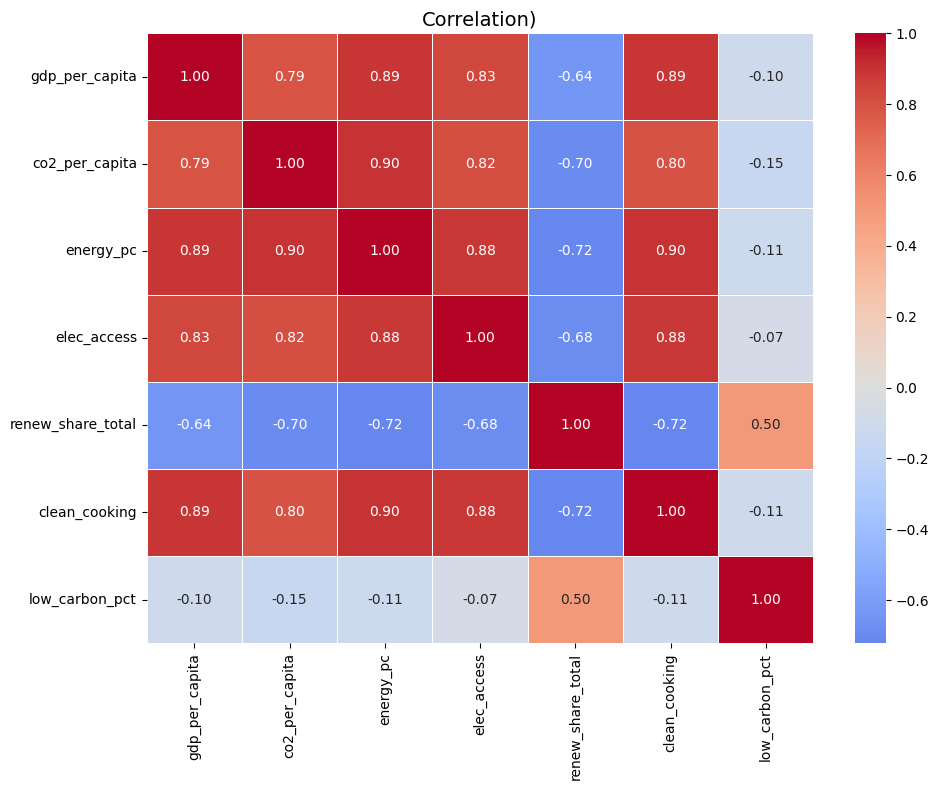

In [35]:
cols_for_corr = [
    'gdp_per_capita', 
    'co2_per_capita', 
    'energy_pc', 
    'elec_access', 
    'renew_share_total',
    'clean_cooking',
    'low_carbon_pct'
]

corr_matrix = df_clean[cols_for_corr].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,        
    fmt=".2f",        
    cmap='coolwarm',   
    linewidths=0.5,    
    center=0           
)

plt.title("Correlation)", fontsize=14)
plt.tight_layout()
plt.show()

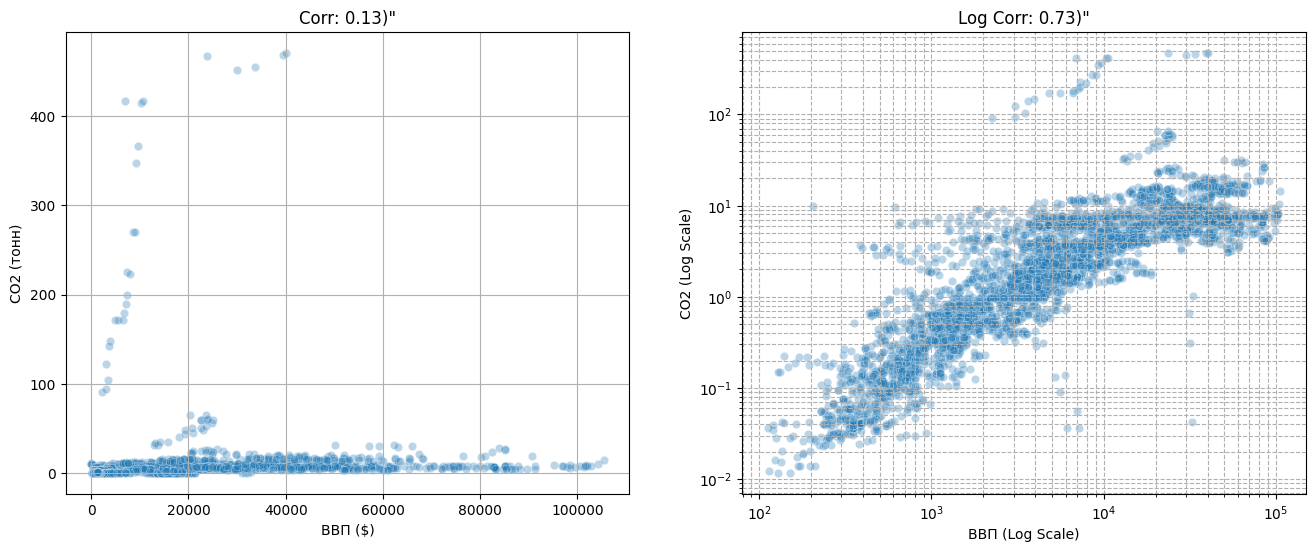

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


sns.scatterplot(data=df_clean, x='gdp_per_capita', y='co2_per_capita', alpha=0.3, ax=ax[0])
ax[0].set_title(f'Corr: {correlation:.2f})"')
ax[0].set_xlabel('ВВП ($)')
ax[0].set_ylabel('CO2 (тонн)')
ax[0].grid(True)

sns.scatterplot(data=df_clean, x='gdp_per_capita', y='co2_per_capita', alpha=0.3, ax=ax[1])
ax[1].set_xscale('log') 
ax[1].set_yscale('log')
ax[1].set_title(f'Log Corr: {log_corr:.2f})\"')
ax[1].set_xlabel('ВВП (Log Scale)')
ax[1].set_ylabel('CO2 (Log Scale)')
ax[1].grid(True, which="both", ls="--")

plt.show()